In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

In [2]:
data = pd.read_csv("final_preprocessed_data.csv")
print("Data shape:", data.shape)

Data shape: (884751, 43)


In [3]:
X = data.drop(columns=['won_county'])
y = data['won_county']

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)

Feature matrix X shape: (884751, 42)
Target vector y shape: (884751,)


## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# 5% Sampling
X_sample = X.sample(frac=0.05, random_state=42)
y_sample = y.loc[X_sample.index]

# Standardize
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Define Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)

# Define hyperparameter
param_dist_dt = {
    'max_depth': randint(3, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    estimator=dt_clf,
    param_distributions=param_dist_dt,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

#  Fit
random_search_dt.fit(X_sample_scaled, y_sample)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a23d9090>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a1dd6b90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a1dd5010>},
                   random_state=42, scoring='f1', verbose=2)

In [21]:
# Output best params
print("\nBest Decision Tree Parameters (5% Sample Tuning):")
print(random_search_dt.best_params_)

# Cross-validation on 5% sample
cv_results_dt_sample = cross_validate(
    random_search_dt.best_estimator_, X_sample_scaled, y_sample,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False
)

print("\nQuick Decision Tree Cross-Validation Results (5% sample):")
for metric in cv_results_dt_sample:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_dt_sample[metric]):.4f}")



Best Decision Tree Parameters (5% Sample Tuning):
{'criterion': 'entropy', 'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 13}

Quick Decision Tree Cross-Validation Results (5% sample):
test_accuracy: 0.9118
test_precision: 0.9079
test_recall: 0.9140
test_f1: 0.9110
test_roc_auc: 0.9742


### Final Model for Decision Tree

In [23]:
# Final Decision Tree

# Standardize the full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the final Decision Tree model with best params from 5% tuning
dt_final = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=23,
    min_samples_leaf=1,
    min_samples_split=13,
    random_state=42
)

# Cross-validation
cv_results_dt_final = cross_validate(
    dt_final, X_scaled, y,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False,
    n_jobs=-1
)


In [24]:
# Output average cross-validation results
print("\n=== Decision Tree Full Data 5-Fold CV Results ===")
for metric in cv_results_dt_final:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_dt_final[metric]):.4f}")


=== Decision Tree Full Data 5-Fold CV Results ===
test_accuracy: 0.6952
test_precision: 0.7200
test_recall: 0.6735
test_f1: 0.6670
test_roc_auc: 0.7221


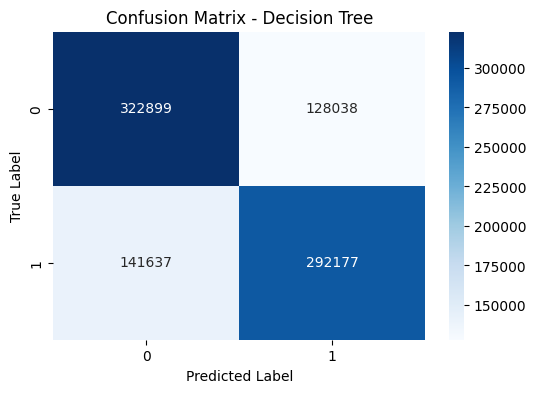


Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71    450937
           1       0.70      0.67      0.68    433814

    accuracy                           0.70    884751
   macro avg       0.70      0.69      0.69    884751
weighted avg       0.70      0.70      0.70    884751



In [27]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns

# Predict cross-validated results
y_pred_dt = cross_val_predict(dt_final, X_scaled, y, cv=5, n_jobs=-1)

# Confusion Matrix
conf_mat_dt = confusion_matrix(y, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report - Decision Tree:")
print(classification_report(y, y_pred_dt))


## Random Forest

In [4]:
# Sample 5% of the data
X_sample = X.sample(frac=0.05, random_state=42)
y_sample = y.loc[X_sample.index]

scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

In [25]:
# Define Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define hyperparameter search space
param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

# Setup RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Train RandomizedSearchCV
random_search_rf.fit(X_sample_scaled, y_sample)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a1c73a90>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a1cd2e50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a1c66090>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a02a1c6b990>},
                   random_state=42, scoring='f1', verbose=2)

In [26]:
# Output best parameters
print("\nBest Random Forest Parameters (5% Sample Tuning):")
print(random_search_rf.best_params_)

# Cross-validation evaluation with the best model
cv_results_rf_sample = cross_validate(
    random_search_rf.best_estimator_, X_sample_scaled, y_sample,
    cv=3,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False
)

# Output average cross-validation results
print("\nQuick Random Forest Cross-Validation Results (5% sample):")
for metric in cv_results_rf_sample:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_rf_sample[metric]):.4f}")



Best Random Forest Parameters (5% Sample Tuning):
{'max_depth': 49, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}

Quick Random Forest Cross-Validation Results (5% sample):
test_accuracy: 0.9145
test_precision: 0.9084
test_recall: 0.9195
test_f1: 0.9139
test_roc_auc: 0.9778


### Final Random Forest Model

In [15]:
# Final Random Forest
# Standardize the full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Random Forest model with best params
rf_final = RandomForestClassifier(
    n_estimators=120,
    max_depth=49,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv_results_rf_final = cross_validate(
    rf_final, X_scaled, y,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False,
    n_jobs=-1
)

In [16]:
# Output average cross-validation results
print("\n=== Random Forest Full Data 5-Fold CV Results ===")
for metric in cv_results_rf_final:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_rf_final[metric]):.4f}")


=== Random Forest Full Data 5-Fold CV Results ===
test_accuracy: 0.6860
test_precision: 0.6920
test_recall: 0.6823
test_f1: 0.6705
test_roc_auc: 0.7150


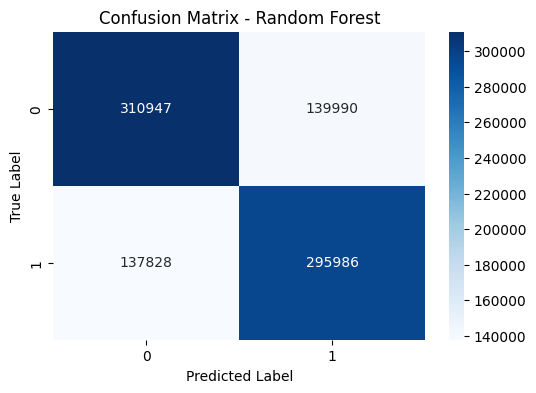


Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69    450937
           1       0.68      0.68      0.68    433814

    accuracy                           0.69    884751
   macro avg       0.69      0.69      0.69    884751
weighted avg       0.69      0.69      0.69    884751



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns

# Predict cross-validated results
y_pred_rf = cross_val_predict(rf_final, X_scaled, y, cv=5, n_jobs=-1)

# Confusion Matrix
conf_mat_rf = confusion_matrix(y, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report - Random Forest:")
print(classification_report(y, y_pred_rf))


Top 10 Important Features for Random Forest:
total_media_mentions (log): 0.0911
fox headline mentions (log): 0.0909
nyt lead paragraph mentions (log): 0.0760
nyt headline mentions (log): 0.0643
percent citizen, voting age population citizen, 18 and over population male: 0.0336
percent total population two or more races white and american indian and alaska native: 0.0307
percent citizen, voting age population citizen, 18 and over population female: 0.0303
estimate race alone or in combination with one or more other races total population black or african american (log): 0.0265
estimate total population one race black or african american (log): 0.0260
citizenship_female_minus_male: 0.0259


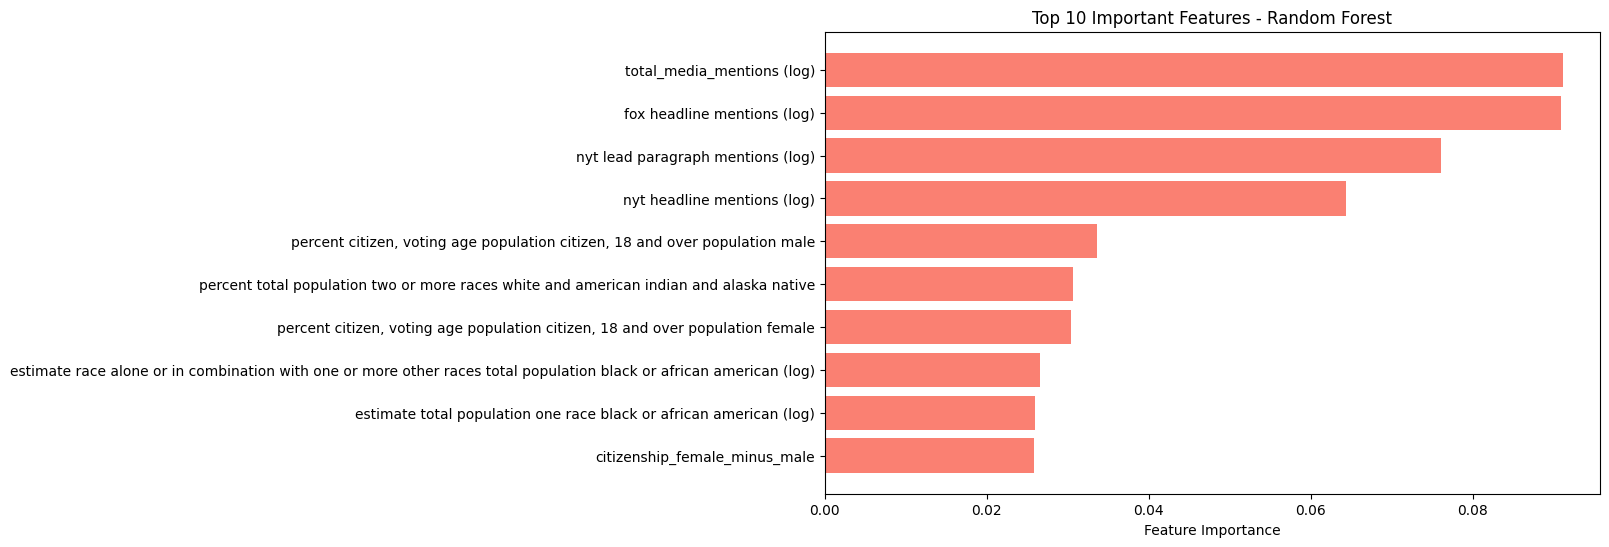

In [8]:

# Fit Random Forest on full dataset to extract feature importance
rf_final.fit(X_scaled, y)
feature_importance_rf = rf_final.feature_importances_

# Sort features by importance
importances_rf = sorted(zip(feature_importance_rf, X.columns), reverse=True)

# Display top 10 most important features
print("\nTop 10 Important Features for Random Forest:")
for i in range(10):
    print(f"{importances_rf[i][1]}: {importances_rf[i][0]:.4f}")

# Plot Top 10 Important Features
plt.figure(figsize=(10,6))
plt.barh([x[1] for x in importances_rf[:10]], [x[0] for x in importances_rf[:10]], color='salmon')
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.show()